In [1]:
#Imports
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.stats import qmc

#Mise en place de l'algo des SVM sur des données quelconques

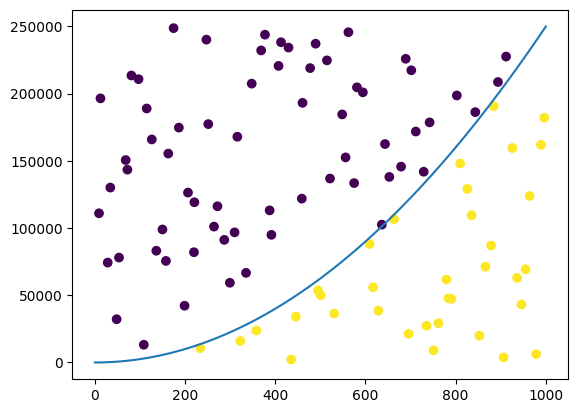

In [2]:
#Données

def f(x):
  y = np.log(1+x) + (1/4)*x**2 - 7
  return y

xlim = 1000
ylim = f(xlim)
n_data = 100

data = np.random.rand(n_data,2) #choix aléatoire sans carré latin
data[:,0] *= xlim
data[:,1] *= ylim

sampler = qmc.LatinHypercube(d=2) #Méthode des carrés latins.
sample = sampler.random(n=n_data)
sample[:,0] *= xlim
sample[:,1] *= ylim
data = sample

values = np.apply_along_axis(f, 0, data[:,0])
labels = 2*(values > data[:,1]) - 1 #labels -1 ou 1

def label_from_point(p): #on généralise ce qui sera utile pour ajouter des points dans la partie refinement
    x = p[0]
    y = p[1]
    return 2*(f(x) > y) - 1

plt.scatter(data[:,0], data[:,1], c=labels) #données
plt.plot(np.linspace(0,xlim,100), f(np.linspace(0,xlim,100))) #le plan a retrouver par SVM
plt.show()


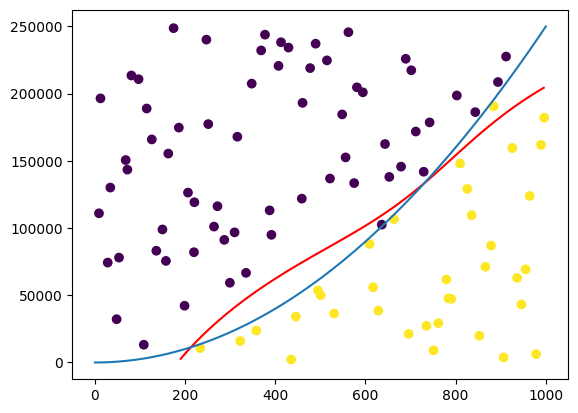

In [3]:
#training
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)

#plot du plan contenu dans le SVM
X = data
y = labels
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot(np.linspace(0,xlim,100), f(np.linspace(0,xlim,100))) #le plan a retrouver par SVM en bleu
plt.show()

In [4]:
#Partie "refinement"
from scipy.optimize import minimize

n_ref = 20

def m_dist_nearest(x):
    return -np.min(np.sum((x-data)**2, axis=1))

def decision(x):
    return clf.decision_function([x])[0]

for step in range(0,n_ref+1):
    xmin = min(data[:,0])
    xmax = max(data[:,0])
    ymin = min(data[:,1])
    ymax = max(data[:,1])
    res = minimize(
        fun=m_dist_nearest,
        x0=np.array([(xmin+xmax)/2, (ymin+ymax)/2]),          # initial guess ON or NEAR the boundary
        constraints={'type': 'eq', 'fun': decision},
        bounds=[(xmin, xmax), (ymin, ymax)],  # optional
        method='SLSQP'
    )
    x_r = res.x
    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [label_from_point(x_r)]), axis=0)
    clf.fit(data, labels)


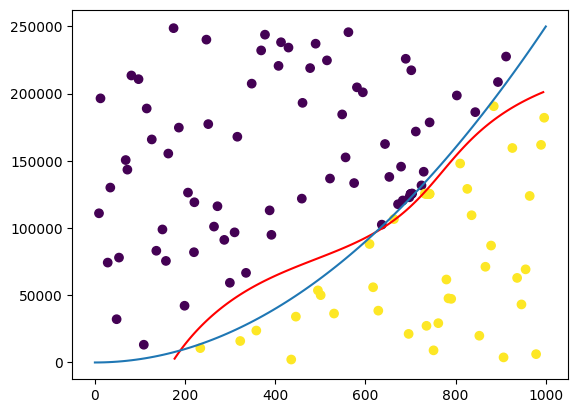

In [5]:
#Observons à présent le plot du SVM mis à jour
x_min = min(data[:,0])
x_max = max(data[:,0])
y_min = min(data[:,1])
y_max = max(data[:,1])
X = data
y = labels
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot(np.linspace(0,xlim,100), f(np.linspace(0,xlim,100))) #le plan a retrouver par SVM en bleu
plt.show()

#Modèle physique de la clarinette (Par Coline, modèle Olivier)

Temps d'exécution (s) : 6.710575342178345


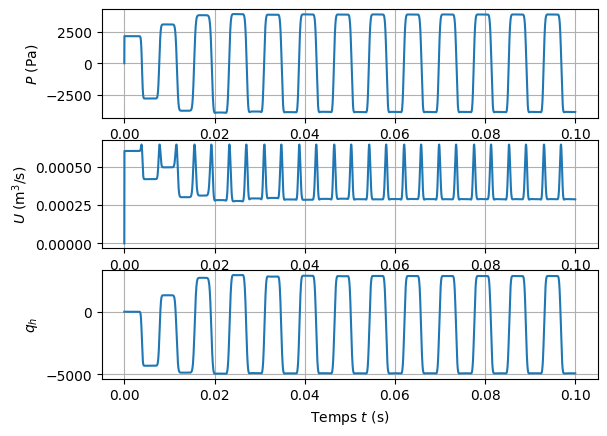

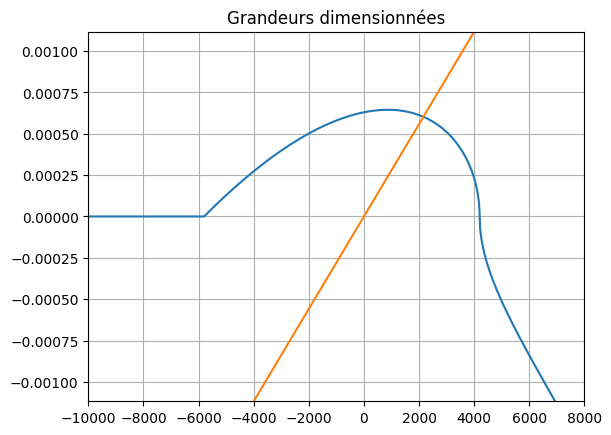

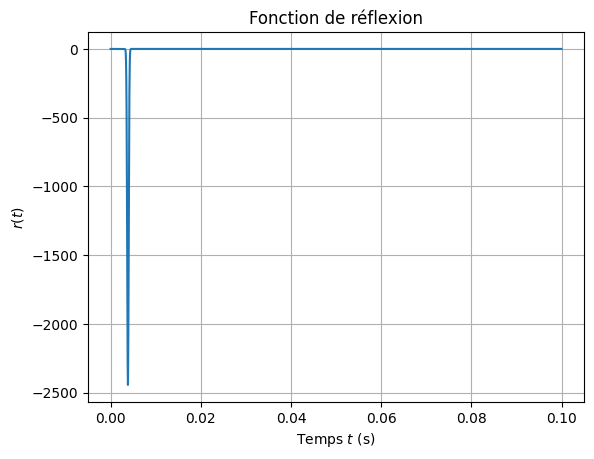

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os
from time import time
from numba import njit

# PARAMETRES PHYSIQUES ET VARIABLES

T_sec = 0.1           # durée simulée (s)

# Paramètres physiques

T_deg = 20             # température (°C)
T_K = 273.15 + T_deg   # température (K)
c = 20.05*np.sqrt(T_K) # vitesse du son (m/s)
rho = 1.292*273.15/T_K # masse volumique de l'air (kg/m^3)

# Paramètres d'anche et de résonateur

H = 10**(-3)           # ouverture d'anche au repos (m)
w = 1.3*10**(-2)       # largeur du canal d'anche (m)
P_M = 10*10**3         # pression de plaquage (Pa)
Ks = P_M / H           # raideur anche (Pa/m)
gamma = 0.42           # pression dans la bouche adimensionnée --> entre 1/3 et 1/2
P_m = gamma * P_M      # pression dans la bouche (Pa)
zeta = 0.6             # paramètre d'ouverture d'anche adimensionné --> entre 0.2 et 0.6
U_A = w*H*np.sqrt(2/rho*P_M)
Zc = zeta*P_M/U_A      # impédance caractéristique (kg/s)
S = rho*c/Zc           # section du résonateur (m^2)
L = 0.66               # longueur du résonateur (m)

# Paramètres utiles pour la simulation

T = 2*L/c               # temps de parcours d'un aller-retour (s)
delta_t = T/128         # pas de temps (s)



# FONCTIONS

# Fonction de réflexion
@njit
def reflexion(t, width_T=0.1, T=T):
    """
    Fonction de réflexion r(t), de la forme gaussienne :
        r(t) = a * exp[-b(t-T)^2]

    Parameters
    ----------
        t : float ou array, instant temporel >= 0 (s)
        width_T : float, largeur à mi-hauteur en proportion de T (en %)
        T : float, temps de parcours aller-retour (s)

    Returns
    -------
        float ou array, valeur de la fonction de réflexion en t
    """
    b = 4 * np.log(2) / (width_T*T)**2
    gauss = np.exp(-b * (t-T)**2)
    A = np.trapz(gauss, dx=delta_t) # intégration trapézoïdale
    a = -1/A
    return a*gauss


# Caractéristique non-linéaire
@njit
def F(P, gamma, zeta, P_M, Zc):
    """
    Caractéristique non-linéaire F telle que u = F(P_m-p)

    Parameters
    ----------
        P : float, pression dans le bec (Pa)
        gamma : float, pression dans la bouche adimensionnée
        zeta : float, paramètre d'ouverture d'anche adimensionné
        P_M : float, pression de plaquage
        Zc : float, impédance caractéristique
    Returns
    -------
        U : float, débit volumique dans le bec
    """
    p = P/P_M # pression adimensionnée
    if np.abs(gamma-p) <= 1:
        u = zeta * (1+p-gamma) * np.sqrt(np.abs(gamma-p)) * (gamma-p)/np.abs(gamma-p) # débit adimensionné
    else :
        u = 0
    U = u*P_M/Zc # débit dimensionné
    return U

@njit
def func_dicho(P, params):
    """
    Fonction dont on veut trouver le zéro par dichotomie

    Parameters
    ----------
        P : float, valeur de la pression dans le bec à laquelle on évalue la fonction
        params : array
    """
    qh = params[0]
    gamma = params[1]
    zeta = params[2]
    P_M = params[3]
    Zc = params[4]
    return F(P, gamma, zeta, P_M, Zc) - 1/Zc*(P-qh)

@njit
def dichotomie(func, params, a, b, n, tol=1e-9):
    """
    Trouver l'abcisse m tel que func(m) = 0 par dichotomie

    Parameters
    ----------
        func : fonction, fonction dont on cherche l'annulation
        params : array, paramètres d'entrée de la fonction
        a : float, borne minimale de l'intervalle de recherche
        b : float, borne maximale de l'intervalle de recherche
        tol : float, tolérance de précision sur la valeur de l'abcisse obtenue

    Returns
    -------
        m : float, abcisse pour laquelle la fonction s'annule
    """

    if func(a,params)*func(b,params) > 0:
        print("Mauvais choix des bornes de l'intervalle, n=",n)
    else :
        m = (a+b)/2

        while np.abs(a-b) > tol:
            if func(m,params) == 0.:
                return m
            elif func(a,params)*func(m,params) > 0:
                a = m
            else :
                b = m
            m = (a+b)/2

        return m


# BOUCLE TEMPORELLE
@njit
def execution(T_sec, delta_t, gamma, zeta, P_M, Zc):

    temps = np.arange(0, T_sec, delta_t)
    N = len(temps)

    # Initialisation
    U, P, qh = np.zeros(N), np.zeros(N), np.zeros(N)

    # Calcul des fonctions de réflexion
    Lwin = int(5 * T / delta_t)
    t_win = np.arange(0, Lwin) * delta_t
    r = reflexion(t_win)
    r_reverse = r[::-1].copy()

    # Initialisation du buffer circulaire
    outgoing_hist = np.zeros(Lwin)

    # Boucle
    for n in range(1,N):

        # calcul de qh à l'instant t
        qh[n] = np.dot(r_reverse, outgoing_hist) * delta_t

        # calcul de q et f à l'instant t
        # trouver l'intersection entre la courbe F(P) et la droite U = 1/Zc*(P-qh) par dichotomie
        P[n] = dichotomie(func_dicho, [qh[n], gamma, zeta, P_M, Zc], -P_M, P_M, n)
        U[n] = F(P[n], gamma, zeta, P_M, Zc)


        # Mise à jour du buffer circulaire (rotation + ajout)
        w_new = P[n] + Zc * U[n]
        # Rotation des buffers
        outgoing_hist[:-1] = outgoing_hist[1:]
        outgoing_hist[-1] = w_new

    return temps, U, P, qh, r

start = time()
temps, U, P, qh, r = execution(T_sec, delta_t, gamma, zeta, P_M, Zc)
stop = time()

def simulation(T_sec, delta_t, gamma, zeta, P_M, Zc, ret_time=False): #Remise en forme pour pouvoir cartographier ensuite
    start = time()
    _, _, P, _, _ = execution(T_sec, delta_t, gamma, zeta, P_M, Zc)
    stop = time()
    if ret_time:
        return P, stop-start
    else:
        return P

print("Temps d'exécution (s) :", stop-start)

# AFFICHAGE

plt.figure()
plt.subplot(311)
plt.plot(temps,P)
plt.ylabel(r"$P$ (Pa)")
plt.grid()

plt.subplot(312)
plt.plot(temps,U)
plt.ylabel(r"$U$ (m$^3$/s)")
plt.grid()

plt.subplot(313)
plt.plot(temps,qh)
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$q_h$")
plt.grid()
plt.show()

#%%

Pvals = np.linspace(-10000,8000,1000)
Uvals = np.zeros(len(Pvals))
for i in range(len(Pvals)):
    Uvals[i] = F(Pvals[i], gamma, zeta, P_M, Zc)

uvals = Uvals*Zc/P_M
pvals = Pvals/P_M

U_droite = 1/Zc * (Pvals-1)
u_droite = U_droite*Zc/P_M

plt.figure()
plt.plot(Pvals,Uvals)
plt.plot(Pvals,U_droite)
plt.grid()
plt.title("Grandeurs dimensionnées")
plt.xlim(-10000,8000)
plt.ylim(-0.4*P_M/Zc,0.4*P_M/Zc)


refl = reflexion(temps)
plt.figure()
plt.plot(temps,refl)
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$r(t)$")
plt.title("Fonction de réflexion")
plt.grid()

#Cartographie du modèle avec pour paramètres variables gamma et zeta adimensionnés

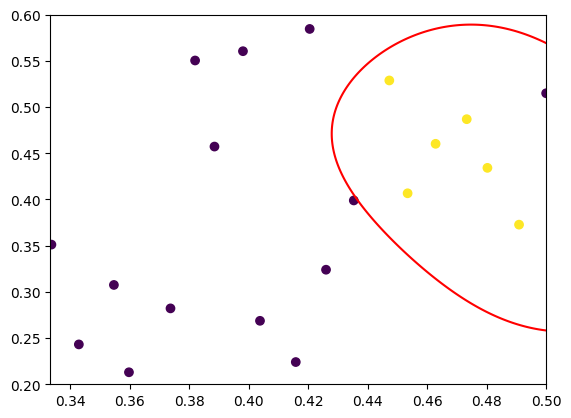

In [8]:
gmin = 1/3
gmax = 1/2
zmin = 0.2
zmax = 0.6

gammas = np.linspace(gmin,gmax,50)
zetas = np.linspace(zmin,zmax,50)
n_sim = 20 # 20 points de départ

#Calculs des descripteurs = labels des points de la cartographie

def epsilon1(P): # établit si oui ou non il y a du son
    eps = 100 # valeur arbitraire, aucune valeur donnée dans le papier de Christophe mais d'après les figures données 10 devrait suffire, P n'excédant pas 0.05 en fin de signal.
    n = len(P)
    moy_last = np.abs((1/n)*np.sum(P[n-(n//3+1):n]))
    #print(moy_last)
    lab = 2*(moy_last > eps)-1 # on prend sur les n//3 derniers samples.
    return lab

#définissons les 20 premiers échantillons avec un carré latin :

sampler = qmc.LatinHypercube(d=2) #Méthode des carrés latins, résultats entre 0 et 1 exclus.
sample = sampler.random(n=n_sim)
g_width = gmax-gmin
z_width = zmax-zmin
sample[:,0] *= g_width
sample[:,0] += gmin
sample[:,1] *= z_width
sample[:,1] += zmin
data = sample

labels = np.zeros(n_sim)

for s in range(n_sim):
    g = sample[s,0]
    z = sample[s,1]
    Zc = z*P_M/U_A
    P = simulation(T_sec, delta_t, g, z, P_M, Zc)
    labels[s] = epsilon1(P)

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()



In [9]:
n_ref = 20

def m_dist_nearest(x): #negatif car on veut le point le plus loin, donc pour maximiser la fonction on minimise sa negation.
    return -np.min(np.sum((x-data)**2, axis=1))

def decision(x):
    return clf.decision_function([x])[0]

for step in range(0,n_ref+1):
    xmin = min(data[:,0])
    xmax = max(data[:,0])
    ymin = min(data[:,1])
    ymax = max(data[:,1])
    res = minimize(
        fun=m_dist_nearest,
        x0=np.array([(xmin+xmax)/2, (ymin+ymax)/2]),
        constraints={'type': 'eq', 'fun': decision},
        bounds=[(xmin, xmax), (ymin, ymax)],  # optional
        method='SLSQP'
    )
    x_r = res.x
    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [epsilon1(simulation(T_sec, delta_t, x_r[0], x_r[1], P_M, Zc))]), axis=0)
    clf.fit(data, labels)

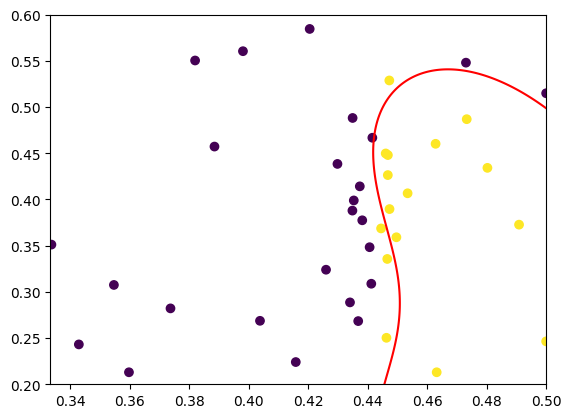

In [10]:
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()

In [11]:
print(np.sum(labels==1)/len(labels))

0.3902439024390244
